# Защита персональных данных клиентов

**Описание исследования**  

Необходимо защитить данные клиентов страховой компании «Хоть потоп»: разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Требуется обоснование корректности метода и его работы.
В результате преобразования данных качество моделей машинного обучения не должно ухудшаться. Подбирать наилучшую модель не требуется.

**Цель исследования**
- Создать метод преобразования данных, который сделает их интерпретацию невозможной, но не ухудшит результаты модели машинного обучения.

**Ход исследования**
- Обзор жанных
- Решение задачи об умножении матрицы признаков на обратимую матрицу
- Алгоритм преобразования данных
- Применение алгоритма преобразования
- Общий вывод

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
try:
    df = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_9_linear_algebra\data\insurance.csv"
    )
except:
    df = pd.read_csv(r"/datasets/insurance.csv")

## Обзор данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Названия столбцов записаны на русском и без змеиного регистра. Исправим это: 

In [4]:
df.columns = ["gender", "age", "salary", "family_members", "insurance_payments"]

Также по какой-то причине тип данных в колонке возраста имеет тип float. Посмотрим, какие уникальные значения там присутствуют (вдруг есть человек 25.5 лет?). 

In [5]:
df.age.sort_values().unique()

array([18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 65.])

Похоже что достаточно поменять тип данных. 

In [6]:
df.age = df.age.astype(int)

In [7]:
df.describe()

,gender,age,salary,family_members,insurance_payments
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


array([[<Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'salary'}>,
        <Axes: title={'center': 'family_members'}>],
       [<Axes: title={'center': 'insurance_payments'}>, <Axes: >]],
      dtype=object)

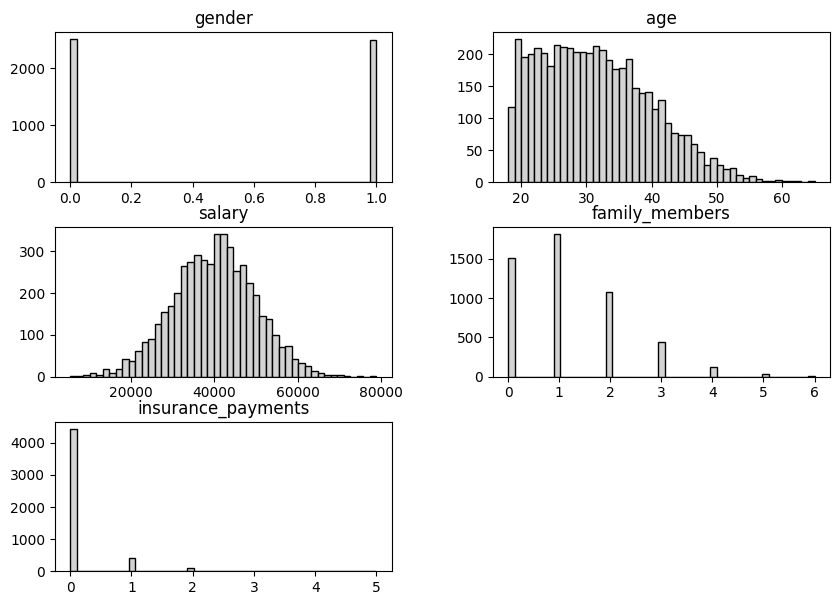

In [8]:
df.hist(bins=47, figsize=(10, 7), edgecolor="black", color="lightgrey", grid=False)

In [9]:
corrs = (
    df.corr()
    .where(np.triu(np.ones(df.corr().shape), 1).astype(bool))
    .stack()
    .reset_index()
    .sort_values(by=0, ascending=False)
)
corrs.columns = ["Clmn_1", "Clmn_2", "Value"]

In [10]:
corrs

,Clmn_1,Clmn_2,Value
6,age,insurance_payments,0.651030
1,gender,salary,0.014910
3,gender,insurance_payments,0.010140
0,gender,age,0.002074
5,age,family_members,-0.006692
2,gender,family_members,-0.008991
8,salary,insurance_payments,-0.014963
4,age,salary,-0.019093
7,salary,family_members,-0.030296
9,family_members,insurance_payments,-0.036290


Возраст и число страховых выплат имеют среднюю корреляцию. Между другими колонками корреляция не замечена. 

Проверим датафрейм на явные дубликаты

In [11]:
df.duplicated().sum()

153

In [12]:
df = df.drop_duplicates()

**Вывод:** датасет содержит 5 колонок: 4 категориальные и 1 количественную.   
В ходе обзора данных была выполнена легкая предобработка: изменены названия колонок, изменен тип данных колонки `age`, удалены дубликаты. Дальнейшая предобработка не требуется, поскольку в датасете отсутствуют пропуски и достижение лучших результатов обучения целью данного исследования не является.

## Задача об умножении матрицы признаков на обратимую матрицу

**Условие задачи:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

  a) Изменится. Приведите примеры матриц.  
  b) Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

**Ответ:** b) Не изменится  

**Доказательство:**

Задача обучения линейной регресси выглядит так:  
$a = X\omega + \omega_{0}$.   
Формула для нахождения $\omega$:   
$\omega = (X^TX)^{-1}X^Ty$

Пусть матрица признаков $X$ умножается на обратимую матрицу-ключ $K$. Преобразованную матрицу признаков обозначим как $R = XK$. Запишем задачу обучения линейной регрессии для преобразованной матрицы признаков, отбросив $\omega_{0}$.

$a = R\omega$. 

$\omega$ определяется как:

$\omega = (R^TR)^{-1}R^Ty$  

Чтобы доказать, что в результате преобразований $X → R$ получаемый вектор ответов $a$ не изменится, воспользуемся двумя свойствами:

$(AB)^T = B^TA^T$  
$(AB)^{-1} = B^{-1}A^{-1}$  

Тогда:

$a = R(R^TR)^{-1}R^Ty = $  

$= (XK)((XK)^T(XK))^{-1}(XK)^Ty =$  

$= (XK)(K^T(X^TX)K)^{-1}(K^TX^T)y =$

$→$**[$ (ABC)^{-1} = C^{-1}B^{-1}A^{-1} $]**$→$

$= X(KK^{-1})(X^TX)^{-1}(K^{T^{-1}}K^T)X^Ty =$  

$→$ **[ $ (KK^{-1}) = E; (K^{T^{-1}}K^T) = E $  ]** $→$

$= XE(X^TX)^{-1}EX^Ty =$

$= X(X^TX)^{-1}X^Ty$  


## Алгоритм преобразования данных 

Чтобы скрыть смысл признаков рассматриваемого датафрейма можно произвести матричное преобразование. Для этого будем использоваить матрицу-ключ, которая преобразует имеющиеся данные и превратит их в набор псевдо-случайных чисел.

Матрица преобразования должна быть обратима и иметь размер ($n$, $n$), где $n$ - число колонок в матрице признаков. 

In [13]:
n = df.drop(columns="insurance_payments").shape[1]

In [14]:
key = np.random.RandomState(42).random((n, n))

In [15]:
key

array([[0.37454012, 0.95071431, 0.73199394, 0.59865848],
       [0.15601864, 0.15599452, 0.05808361, 0.86617615],
       [0.60111501, 0.70807258, 0.02058449, 0.96990985],
       [0.83244264, 0.21233911, 0.18182497, 0.18340451]])

Проверка обратимости

In [16]:
np.linalg.inv(key)

array([[-0.32076901, -0.12766508,  0.06141427,  1.32518674],
       [ 0.35151041, -1.88500014,  1.65560045, -1.0003883 ],
       [ 1.14080312,  1.3467702 , -2.0407373 ,  0.70794071],
       [-0.08202687,  1.42666425, -0.17238177, -0.10600441]])

In [17]:
features = df.drop(columns="insurance_payments")
features.head()

,gender,age,salary,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0


Когда у нас есть ключ, можно преобразовать данные: 

In [18]:
features_transformed = pd.DataFrame(features.values @ key, index=features.index)
features_transformed.head()

,0,1,2,3
0,29822.908329,35127.958687,1024.286164,48143.823952
1,22850.379746,26914.146043,785.064454,36896.601889
2,12627.939787,14874.047975,433.958805,20393.226004
3,25071.437266,29530.327057,859.956818,40463.797343
4,15693.844869,18486.012841,539.613636,25339.498732


Преобразованная матрица содержит в себе набор псевдо-случайных чисел, которые довольно затруднительно воспринимать как информацию о клиентах и каким-либо образом интерпретировать.

Чтобы получить исходную информацию обратно достаточно домножить преобразованную матрицу на обратную матрицу ключа:

In [19]:
features_rebuild = pd.DataFrame(
    features_transformed.values @ np.linalg.inv(key),
    columns=features.columns,
    index=features.index,
).round()
features_rebuild[["gender", "age", "family_members"]] = features_rebuild[
    ["gender", "age", "family_members"]
].astype(int)
features_rebuild.head()

,gender,age,salary,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0


Сравним исходные и восстановленные признаки, чтобы убедиться, что все значения остались прежними

In [20]:
(features - features_rebuild).sum()

gender            0.000000e+00
age               0.000000e+00
salary            1.127773e-10
family_members    0.000000e+00
dtype: float64

Небольшие различия в столбце `salary`  связаны с тем, что тип данных float64 имеет точность лишь 15 знаков после запятой. 

Качество линейной регрессии от произведенных преобразований не изменится, поскольку, как было доказано в предыдущем пункте, умножение матрицы признаков на обратимую матрицу не влияет на конечные значения предсказаний. 

## Применение алгоритма преобразования

Создадим кодировщик-декодировщик для признаков. 

In [21]:
class randomMatrixEncoder:
    def encoder(self, features):
        global types
        types = features.dtypes.to_dict()
        n = features.shape[1]
        check = False
        while check == False:
            key = np.random.RandomState(42).random((n, n))
            try:
                np.linalg.inv(key)
                check = True
            except:
                check = False
        features_transformed = features.values @ key
        return (
            pd.DataFrame(
                features_transformed, index=features.index, columns=features.columns
            ),
            key,
        )

    def decoder(self, features, key):
        features_rebuild = features.values @ np.linalg.inv(key)
        return (
            pd.DataFrame(
                features_rebuild, index=features.index, columns=features.columns
            )
            .round()
            .astype(types)
        )

Выделим признаки и целевые признаки

In [22]:
X = df.drop(columns="insurance_payments")

In [23]:
y = df.insurance_payments

Разделим на выборки

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Обучим модель на признаках без преобразования и посмотрим на ее результаты

In [25]:
model = LinearRegression()

In [26]:
model.fit(X_train, y_train)

LinearRegression()

In [27]:
predictions_pure = model.predict(X_test)

In [28]:
r2_score_pure = r2_score(y_test, predictions_pure)

In [29]:
print("=" * 79)
print(f"\nМетрика R2 до преобразования матрицы признаков = {r2_score_pure:.5}\n")
print("=" * 79)


Метрика R2 до преобразования матрицы признаков = 0.43927



Теперь создадим закодированные признаки

In [30]:
encoder = randomMatrixEncoder()

In [31]:
X_encoded, key = encoder.encoder(X)

In [32]:
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

Сравним, как выглядят тренировочные признаки до и после преобразования

In [33]:
X_train.head(3)

,gender,age,salary,family_members
433,1,30,45200.0,3
4206,1,28,45100.0,0
290,1,22,27900.0,0


In [34]:
X_train_encoded.head(3)

,gender,age,salary,family_members
433,27177.950958,32011.148084,933.439119,43867.059474
4206,27115.030092,31939.391819,930.719028,43767.785923
290,16774.915778,19759.607514,576.317224,27080.139409


Снова обученим модель и произведем вывод ее результатов

In [35]:
model_encoded = LinearRegression()

In [36]:
model_encoded.fit(X_train_encoded, y_train)

LinearRegression()

In [37]:
predictions_encoded = model_encoded.predict(X_test_encoded)

In [38]:
r2_score_encoded = r2_score(y_test, predictions_encoded)

In [39]:
print("=" * 79)
print(f"\nМетрика R2 после преобразования матрицы признаков = {r2_score_encoded:.5}\n")
print("=" * 79)


Метрика R2 после преобразования матрицы признаков = 0.43927



Сравним полученные предсказания при помощи той же метрики R2

In [40]:
r2_score(predictions_pure, predictions_encoded)

1.0

**Вывод:** Предсказания совпадают

Попробуем декодировать тестовые признаки и сравнить их с нетронутыми

In [41]:
X_test_decoded = randomMatrixEncoder().decoder(X_test_encoded, key)

In [42]:
X_test_decoded.head()

,gender,age,salary,family_members
3991,0,19,33800.0,0
1706,0,29,48100.0,3
1052,0,29,40100.0,0
4959,0,43,34500.0,4
1554,0,31,48800.0,1


In [43]:
X_test.head()

,gender,age,salary,family_members
3991,0,19,33800.0,0
1706,0,29,48100.0,3
1052,0,29,40100.0,0
4959,0,43,34500.0,4
1554,0,31,48800.0,1


In [44]:
r2_score(X_test_decoded, X_test)

1.0

**Вывод:** Декодировщик работает корректно

## Общий вывод

**В ходе выполнения исследования** была рассмотрена возможность создания алгоритма преобразования данных, скрывающего смысл представленных в датасете величин без ухудшения результатов моделей машинного обучения.  

**Выполнены следующие этапы:**
- **Обзор данных**  

  В ходе обзора данных была также произведеная легкая предобработка данных с целью стандартизации названий колонок, удаления дубликатов и оптимизации типов данных;  
  
- **Решение задачи об умножении матрицы признаков на обратимую матрицу**  

  Было доказано, что умножение матрицы признаков на обратимую матрицу **не влияет** на качество предсказаний модели линейной регрессии;  
  
  
- **Создание алгоритма преобразования**  

  Описана методика создания матрицы преобразований, кодирующей признаки таким образом, чтобы их было проблематично интерпретировать;  
  
- **Применение алгоритма преобразования**   

  Был создан класс randomMatrixEncoder, содержащий в себе кодировщик и декодировщик данных. При передаче датафрейма признаков кодировщику, возвращаются закодированный датафрейм и матрица-ключ; декодировщику, в свою очередь, передается закодированный датафрейм и ключ, а возвращается декодированный исходный датафрейм.    
  Созданный класс испытан на данных для обучения модели линейной регрессии.   
  
**Получены следующие результаты:**  

Класс **randomMatrixEncoder** успешно применен для преобразования признаков представленного в работе датасета, содержащего данные о клиентах страховой компании «Хоть потоп».   

Пример данных после произведенного преобразования: 

In [45]:
X_test_encoded.sample(15)

,gender,age,salary,family_members
3996,24714.834897,29110.745727,849.840715,39907.385794
152,22668.589755,26699.029058,778.091084,36588.672220
2138,28136.967808,33141.341209,964.879655,45409.471413
694,16119.306966,18984.484586,555.381428,26031.112308
4918,28556.145933,33637.206061,979.540978,46086.907807
3573,21525.804962,25354.841174,739.581223,34749.540055
1769,26758.626967,31516.333596,919.444133,43191.770687
4330,34030.079184,40082.636395,1167.420870,54926.714430
3210,25189.995383,29671.516895,863.710067,40657.412505
3452,27116.372786,31938.298150,930.242091,43763.406597


При обучении модели линейной регрессии на преобразованных данных получены те же результаты, что и на чистых данных: 

In [46]:
print(
    f"\nR2 на преобразованных данных = {r2_score_encoded:.5}, на чистых данных = {r2_score_pure:.5}\n"
)


R2 на преобразованных данных = 0.43927, на чистых данных = 0.43927



Работоспособность декодировщика также проверена - данные после обратных преобразований соответствуют чистым данным.